In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
    FluxPointsEstimator,
    FluxPointsDataset,
    ReflectedRegionsBackgroundMaker,
    plot_spectrum_datasets_off_regions,
)
from gammapy.modeling import Fit, Parameter, Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis
from itertools import combinations

In [3]:
import scipy.stats as stats
import math
import statistics

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
l = [0,0.02,0.05,0.1,0.5]
livetime = [10,8,5,4,2] * u.h
n_obs = [100,125,200,250,500]
model_name = ['PowerLaw', 'Cutoff_value \n= 50TeV', 'Cutoff_value \n= 20TeV', 'Cutoff_value \n= 10TeV', 'Cutoff_value \n= 2TeV']
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 40), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 200), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [7]:
rows, cols = (5, 5) 
model = [[0 for i in range(cols)] for j in range(rows)]
print(model) 

[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]


In [8]:
simu = []
for j in range(5):
    for i in range(5):
        sim = ExpCutoffPowerLawSpectralModel(
            index=2.22,
            amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
            reference=1 * u.TeV,
            lambda_=l[j] * u.Unit("TeV-1"),
            alpha = 1,
        )
        mod = SkyModel(spectral_model=sim)
        model[i][j]=mod
    simu.append(sim)
    print(simu[j])

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 0.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e-02   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    inde

In [9]:
obs = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        obs[i][j]=Observation.create(pointing=pointing, livetime=livetime[i], irfs=irfs)
        print(obs[i][j])

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 36000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 18000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 14400.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 7200.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 36000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 28800.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 18000.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 14400.0 s

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 7200.0 s

Info for OBS

In [10]:
dataset = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        dataset_empty = SpectrumDataset.create(
            e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
        )
        maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
        dataset[i][j]=maker.run(dataset_empty, obs[i][j])
        print(dataset[i][j])

SpectrumDataset

    Name                            : 1 

    Total counts                    : nan 
    Total predicted counts          : nan
    Total background counts         : 4417.82

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 3.60e+04 s

    Number of total bins            : 0 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : nan 
    Total predicted counts          : nan
    Total background counts         : 3534.26

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 0 
    Number of fit bins 

SpectrumDataset

    Name                            : 1 

    Total counts                    : nan 
    Total predicted counts          : nan
    Total background counts         : 883.56

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 7.20e+03 s

    Number of total bins            : 0 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : nan 
    Total predicted counts          : nan
    Total background counts         : 4417.82

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 3.60e+04 s

    Number of total bins            : 0 
    Number of fit bins  

In [11]:
data = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        dataset[i][j].model = model[i][j]
        dataset[i][j].fake(random_state=42)
        print(dataset[i][j])
        data[i][j]=dataset[i][j]

SpectrumDataset

    Name                            : 1 

    Total counts                    : 4378 
    Total predicted counts          : nan
    Total background counts         : 4417.82

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 3.60e+04 s

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : 3498 
    Total predicted counts          : nan
    Total background counts         : 3534.26

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 39 
    Number of fit b

SpectrumDataset

    Name                            : 1 

    Total counts                    : 3498 
    Total predicted counts          : nan
    Total background counts         : 3534.26

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 2.88e+04 s

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0


SpectrumDataset

    Name                            : 1 

    Total counts                    : 2183 
    Total predicted counts          : nan
    Total background counts         : 2208.91

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.80e+04 s

    Number of total bins            : 39 
    Number of fit b

In [12]:
data_onoff = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        dataset_onoff = SpectrumDatasetOnOff(
            aeff=data[i][j].aeff,
            edisp=data[i][j].edisp,
            models=model[i][j],
            livetime=livetime[i],
            acceptance=1,
            acceptance_off=5,
        )
        dataset_onoff.fake(background_model=data[i][j].background)
        print(dataset_onoff)
        data_onoff[i][j]=dataset_onoff

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 7914 
    Total predicted counts          : 7904.29
    Total off counts                : 22080.00

    Total background counts         : 4416.00

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 1.00e+01 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 26.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 6349 
    Total predicted counts          : 6315.43
    Total off counts                : 17624.00

    Total background counts         : 3524.80

    Eff

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 3139 
    Total predicted counts          : 3101.50
    Total off counts                : 8889.00

    Total background counts         : 1777.80

    Effective area min              : 2.80e+04 m2
    Effective area max              : 5.73e+06 m2

    Livetime                        : 4.00e+00 h

    Number of total bins            : 39 
    Number of fit bins              : 39 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 36.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 1561 
    Total predicted counts          : 1553.05
    Total off counts                : 4456.00

    Total background counts         : 891.20

    Effect

In [13]:
%%time
datas = [[0 for i in range(cols)] for j in range(rows)]
for j in range(5):
    for i in range(5):
        datasets = []
        for idx in range(n_obs[i]):
            data_onoff[i][j].fake(random_state=idx, background_model=data[i][j].background)
            data_onoff[i][j].name = f"obs_{idx}"
            datasets.append(data_onoff[i][j].copy())
        datas[i][j]=datasets

CPU times: user 40.9 s, sys: 877 ms, total: 41.7 s
Wall time: 45.8 s


/home/rishank/anaconda2/envs/gammapy-0.15/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


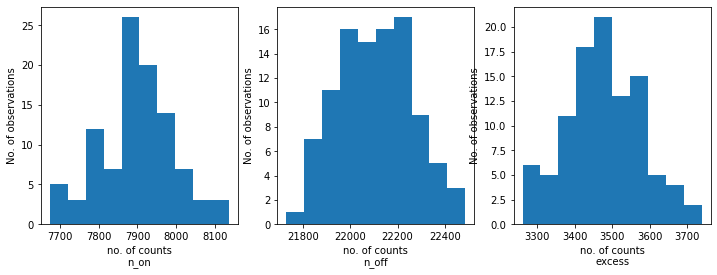

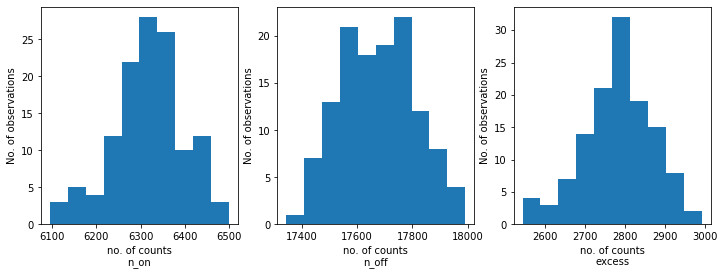

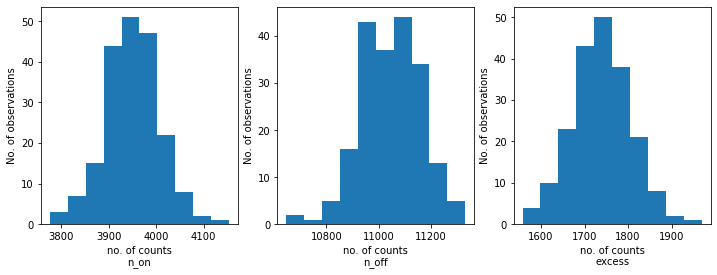

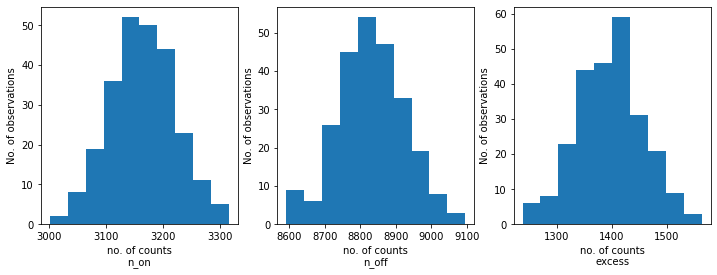

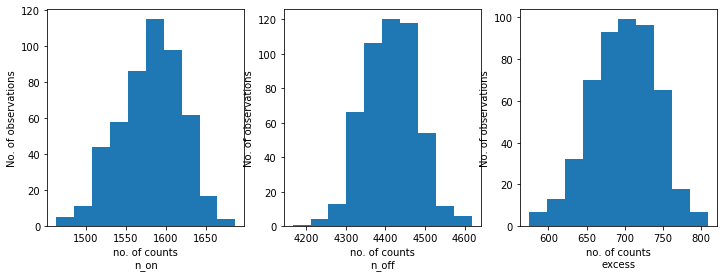

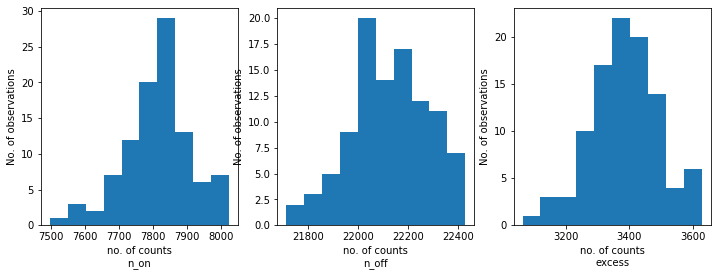

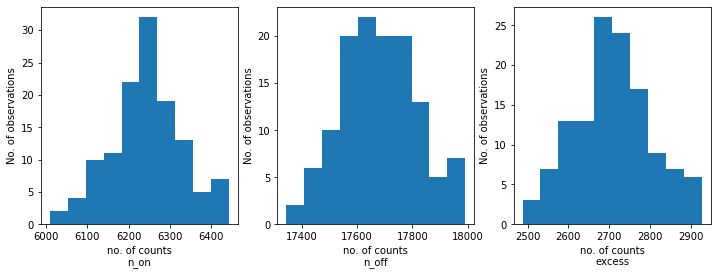

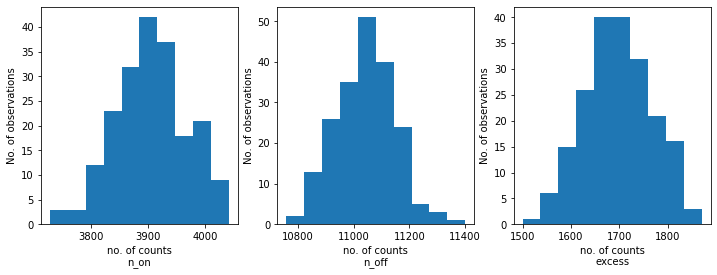

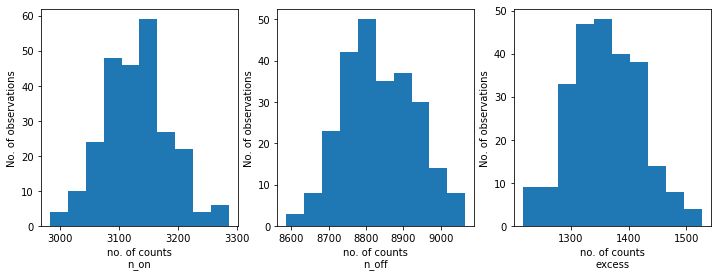

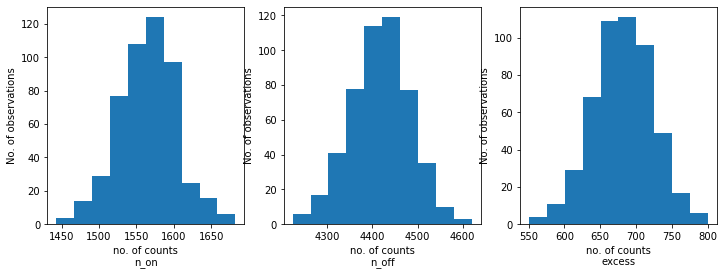

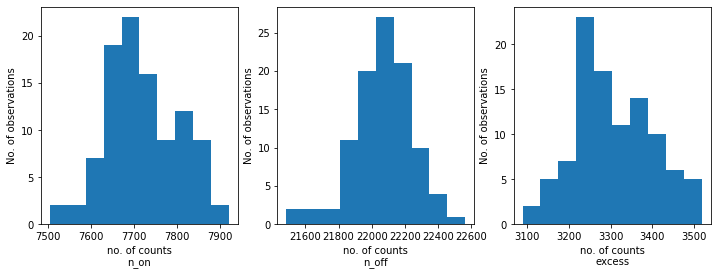

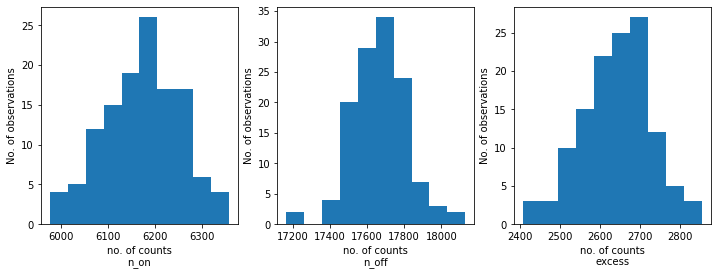

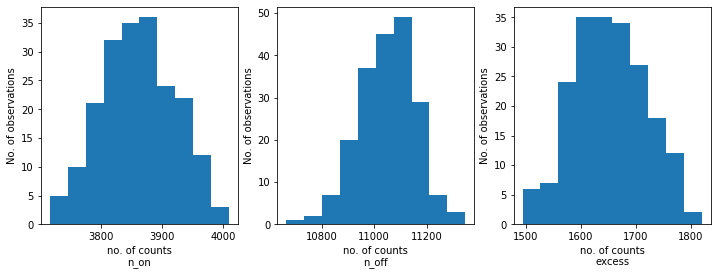

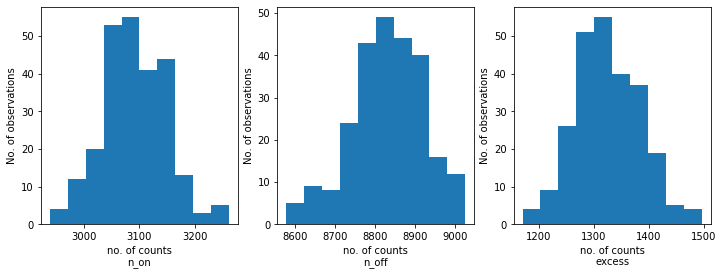

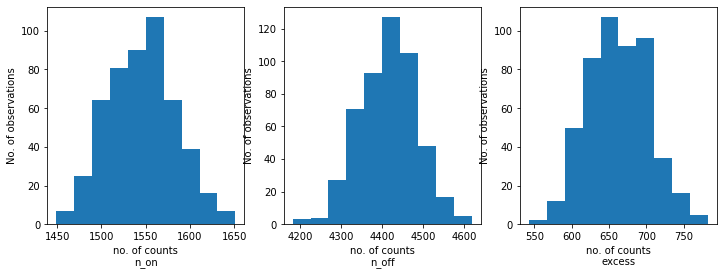

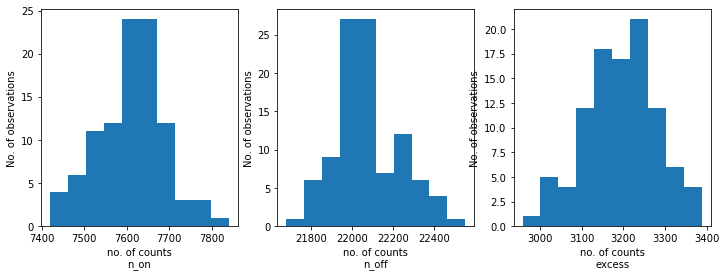

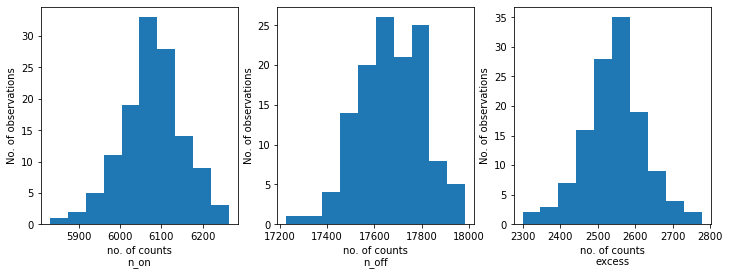

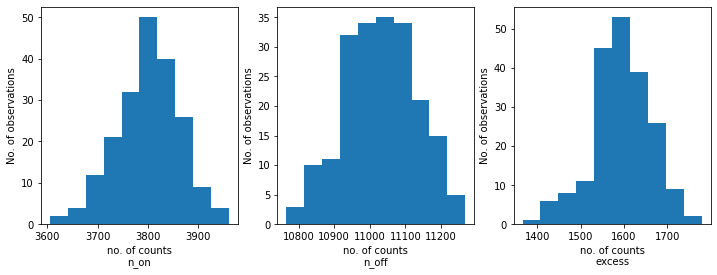

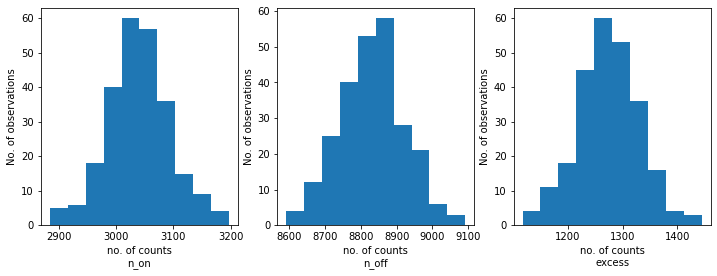

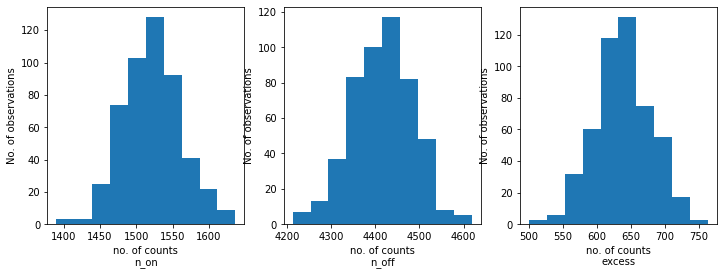

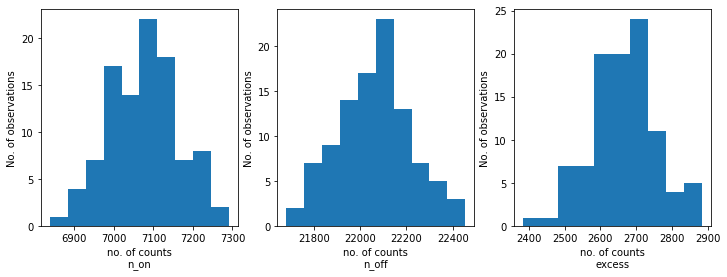

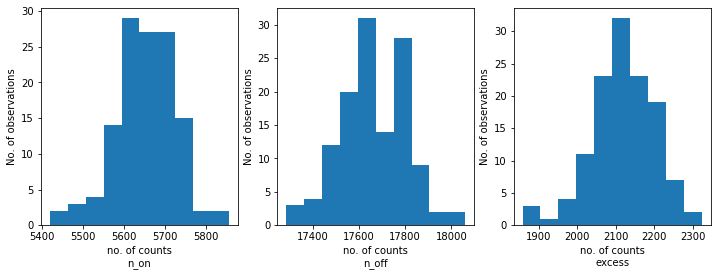

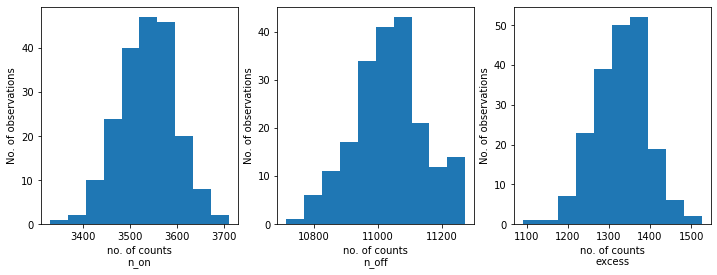

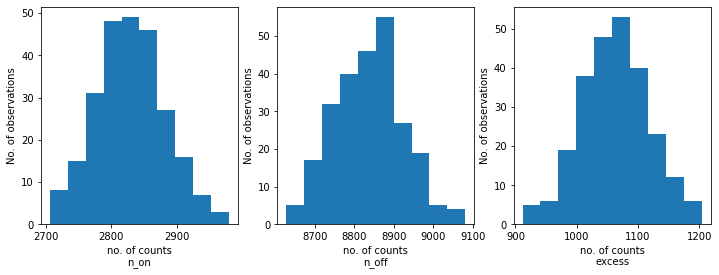

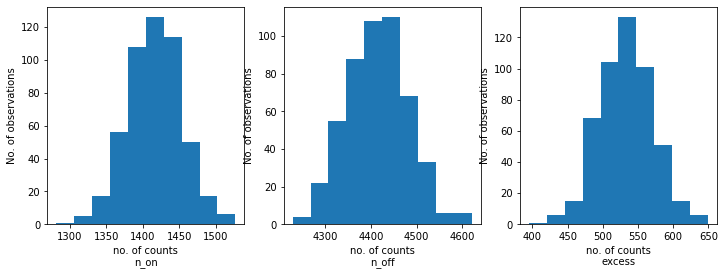

In [14]:
for j in range(5):
    for i in range(5):
        n_on = [dataset.counts.data.sum() for dataset in datas[i][j]]
        n_off = [dataset.counts_off.data.sum() for dataset in datas[i][j]]
        excess = [dataset.excess.data.sum() for dataset in datas[i][j]]
        
        fix, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].hist(n_on)
        axes[0].set_xlabel("no. of counts\nn_on")
        axes[0].set_ylabel("No. of observations")
        axes[1].hist(n_off)
        axes[1].set_xlabel("no. of counts\nn_off")
        axes[1].set_ylabel("No. of observations")
        axes[2].hist(excess)
        axes[2].set_xlabel("no. of counts\nexcess");
        axes[2].set_ylabel("No. of observations")

In [15]:
e_edges = np.logspace(-1.5, 2.0, 10) * u.TeV
results = [[0 for i in range(cols*2)] for j in range(rows)]
dataset_stacked = [[0 for i in range(cols*2)] for j in range(rows)]

In [16]:
spectra = ExpCutoffPowerLawSpectralModel(index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV, lambda_=0 * u.Unit("TeV-1"), alpha = 1)
#spectra = PowerLawSpectralModel(index=2, amplitude=2e-11 * u.Unit("cm-2 s-1 TeV-1"), reference=1 * u.TeV)

model_0 = SkyModel(spectral_model=spectra)

In [17]:
%%time
for j in range(5):
    for i in range(5):
        st = Datasets(datas[i][j]).stack_reduce()
        st.models = model_0.copy()
        dataset_stacked[i][j] = st
        print(dataset_stacked[i][j].livetime)
        dataset_stacked[i][j+5] = st
        print(dataset_stacked[i][j+5].livetime)
        

1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
1000.0 h
CPU times: user 1min 13s, sys: 162 ms, total: 1min 13s
Wall time: 1min 16s


In [18]:

for j in range(5):
    for i in range(5):
        dataset_stacked[i][j].parameters["lambda_"].frozen = True
        fit = Fit([dataset_stacked[i][j]])
        result = fit.run()
        
        print(result.parameters.to_table())
        print(result)
        results[i][j] = result
        
        
for j in range(5):
    for i in range(5):
        dataset_stacked[i][j+5].parameters["lambda_"].frozen = False
        fit = Fit([dataset_stacked[i][j+5]])
        result = fit.run()
        
        print(result.parameters.to_table())
        print(result)
        results[i][j+5] = result

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.217e+00 1.445e-03                nan nan  False
amplitude 1.289e-12 3.075e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 0.000e+00 0.000e+00          TeV-1 nan nan   True
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 92
	total stat : 36.03

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.219e+00 1.445e-03                nan nan  False
amplitude 1.288e-12 3.075e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 0.000e+00 0.000e+00          TeV-1 nan nan   True
    alpha 1.000e+00 0.000e+00                nan nan 

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.355e+00 1.607e-03                nan nan  False
amplitude 1.010e-12 2.891e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 0.000e+00 0.000e+00          TeV-1 nan nan   True
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 98
	total stat : 5430.94

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.354e+00 1.608e-03                nan nan  False
amplitude 1.007e-12 2.888e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 0.000e+00 0.000e+00          TeV-1 nan nan   True
    alpha 1.000e+00 0.000e+00                nan na

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.216e+00 2.035e-03                nan nan  False
amplitude 1.290e-12 4.190e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 2.002e-02 7.051e-04          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 77
	total stat : 40.36

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.217e+00 2.033e-03                nan nan  False
amplitude 1.287e-12 4.182e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 1.975e-02 7.034e-04          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan 

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.218e+00 2.725e-03                nan nan  False
amplitude 1.296e-12 6.153e-15 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 1.039e-01 1.885e-03          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan   True
OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 89
	total stat : 27.77

   name     value     error        unit      min max frozen
--------- --------- --------- -------------- --- --- ------
    index 2.224e+00 4.824e-03                nan nan  False
amplitude 1.280e-12 1.308e-14 cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00 0.000e+00            TeV nan nan   True
  lambda_ 4.948e-01 7.707e-03          TeV-1 nan nan  False
    alpha 1.000e+00 0.000e+00                nan nan 

In [19]:
sim = [[0 for i in range(cols*2)] for j in range(rows)]

for j in range(10):
    for i in range(5):
        s = ExpCutoffPowerLawSpectralModel(
            index=results[i][j].parameters["index"].value,
            amplitude=results[i][j].parameters["amplitude"].value * u.Unit("cm-2 s-1 TeV-1"),
            reference=1 * u.TeV,
            lambda_=results[i][j].parameters["lambda_"].value * u.Unit("TeV-1"),
            alpha = 1,
        )
        print(s)
        sim[i][j]=s

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.216e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 9.705e-05   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.218e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.819e-04   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    inde

    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.219e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.006e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True
ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------

In [20]:
total_stat_list = []
for j in range(10):
    for i in range(5):
        total_stat_list.append(results[i][j].total_stat)

In [21]:
total_stat_list

[36.03235444112693,
 39.427857518320025,
 34.63820913513905,
 38.36962459538063,
 34.45129804479188,
 1062.5163608483601,
 1037.0604672281786,
 1150.5190818434162,
 1072.8899221788329,
 1110.5980786847554,
 3104.8758957636405,
 3049.462387912041,
 3031.3303687993584,
 3048.1090969960946,
 3173.160910144278,
 5430.9405731339675,
 5550.731739721761,
 5512.116829815456,
 5556.470667141351,
 5710.33668123103,
 9946.753292076479,
 9942.547934035416,
 10120.061702811428,
 9971.816804154914,
 10107.787108777919,
 35.9865417258834,
 39.04898119238851,
 34.627161870284226,
 37.88431710243003,
 34.08647127905988,
 40.357452353751114,
 39.649403457578444,
 33.63048437315737,
 29.619550996147396,
 32.78113195585907,
 41.49849181262801,
 24.941082477716712,
 33.56053420112216,
 21.565611285365247,
 36.86616285187329,
 40.842199470666216,
 37.60269401923755,
 25.994580582502444,
 31.532841399902452,
 27.76630077363663,
 27.665118610253657,
 32.32570545070185,
 17.1306775458247,
 27.39519964177007,
 

In [25]:
TS0 = []
TS1 = []
del_TS = []
sq_del = []
for i in range(25):
    TS0.append(total_stat_list[i])
    TS1.append(total_stat_list[i+25])
    del_TS.append(total_stat_list[i] - total_stat_list[i+25])
print(del_TS)
for i in range(5):
    sq_del.append((np.sqrt(del_TS[5*i])+np.sqrt(del_TS[5*i+1])+np.sqrt(del_TS[5*i+2])+np.sqrt(del_TS[5*i+3])+np.sqrt(del_TS[5*i+4]))/5)
print(np.sqrt(del_TS))

[0.045812715243528146, 0.37887632593151466, 0.01104726485482388, 0.4853074929505965, 0.3648267657320048, 1022.158908494609, 997.4110637706001, 1116.888597470259, 1043.2703711826855, 1077.8169467288963, 3063.3774039510126, 3024.521305434324, 2997.7698345982362, 3026.5434857107293, 3136.2947472924047, 5390.098373663302, 5513.129045702523, 5486.122249232953, 5524.937825741449, 5682.570380457393, 9919.088173466225, 9910.222228584715, 10102.931025265603, 9944.421604513143, 10090.507217545319]
[  0.21403905   0.61552931   0.10510597   0.69664015   0.60400891
  31.97122     31.5818154   33.41988327  32.29969615  32.83012255
  55.3477859   54.99564806  54.75189343  55.0140299   56.00263161
  73.41728934  74.25044812  74.068362    74.32992551  75.3828255
  99.5946192   99.55009909 100.51333755  99.72172083 100.45151675]


Text(0, 0.5, 'sqrt (del_TS)')

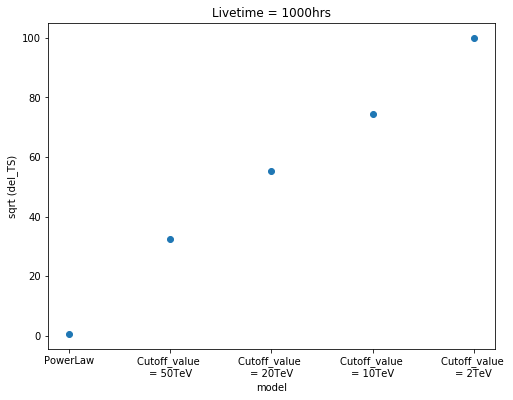

In [26]:
plt.figure(figsize=[8,6])
plt.scatter(model_name,sq_del)
plt.title("Livetime = 1000hrs")
plt.xlabel("model")
plt.ylabel("sqrt (del_TS)")

Text(0, 0.5, 'sqrt (del_TS)')

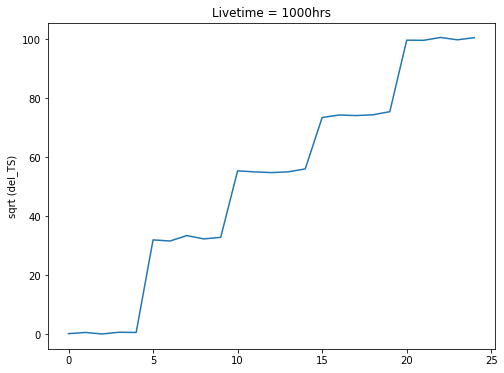

In [27]:
plt.figure(figsize=[8,6])
plt.plot(np.sqrt(del_TS))
plt.title("Livetime = 1000hrs")
plt.ylabel("sqrt (del_TS)")